In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.optim import Adam, lr_scheduler
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

# Dataset

It is a many-to-many task.

In [2]:
narma_df = pd.read_csv('NARMA10.csv', header=None).transpose()
narma_df.columns = ['input', 'target']

narma_df.head(15)

,input,target
0,0.083964,0.00000
1,0.489340,0.00000
2,0.356350,0.00000
3,0.250240,0.00000
4,0.235540,0.00000
5,0.029809,0.00000
6,0.340990,0.00000
7,0.021216,0.00000
8,0.035723,0.00000
9,0.260820,0.00000


In [3]:
narma_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   input   10000 non-null  float64
 1   target  10000 non-null  float64
dtypes: float64(2)
memory usage: 234.4 KB


Show first 10 elems of the series

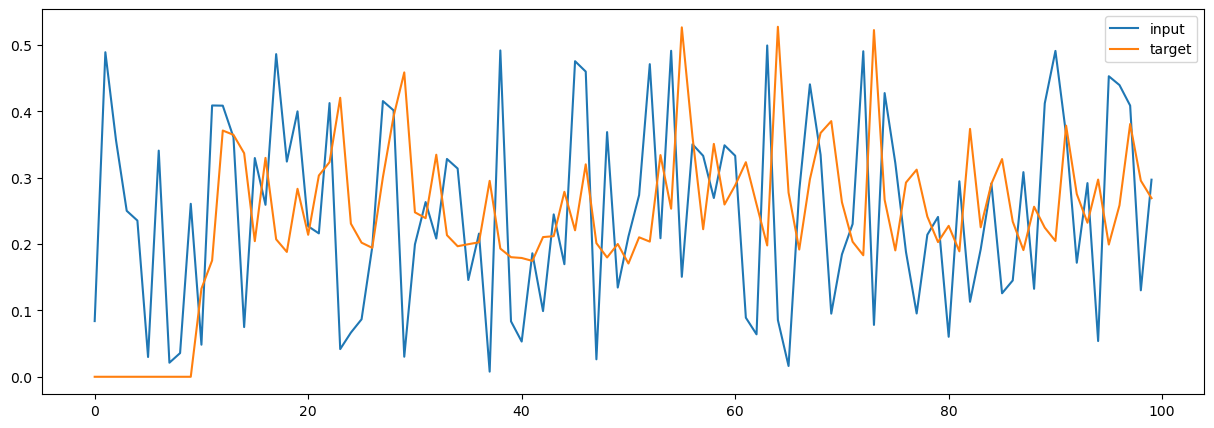

In [4]:
plt.plot(narma_df['input'][:100], label='input')
plt.plot(narma_df['target'][:100], label='target')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()

## Split Tr - Val - Test

In [4]:
tr_df = narma_df.iloc[:4000]
val_df = narma_df.iloc[4000:5000]
test_df = narma_df.iloc[5000:]

## Prepare datsets

Datasets

In [5]:
tr_input = torch.Tensor(tr_df.input.values).unsqueeze(1)
tr_target = torch.Tensor(tr_df.target.values).unsqueeze(1)
print('tr size:', tr_input.shape, tr_target.shape)

val_input = torch.Tensor(val_df.input.values).unsqueeze(1)
val_target = torch.Tensor(val_df.target.values).unsqueeze(1)

test_input = torch.Tensor(test_df.input.values).unsqueeze(1)
test_target = torch.Tensor(test_df.target.values).unsqueeze(1)

devel_input = torch.Tensor(np.concatenate([tr_input, val_input]))
devel_target = torch.Tensor(np.concatenate([tr_target, val_target]))
print('devel size:', devel_input.shape, devel_target.shape)

tr size: torch.Size([4000, 1]) torch.Size([4000, 1])
devel size: torch.Size([5000, 1]) torch.Size([5000, 1])


Dataloaders

In [6]:
batch_size = 32

tr_dataloader = DataLoader(torch.tensor([tr_df.input.values, tr_df.target.values]), batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(torch.tensor([val_df.input.values, val_df.target.values]), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(torch.tensor([test_df.input.values, test_df.target.values]), batch_size=batch_size, shuffle=False)

/tmp/ipykernel_11122/4131595575.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  tr_dataloader = DataLoader(torch.tensor([tr_df.input.values, tr_df.target.values]), batch_size=batch_size, shuffle=False)


# RNN

RNN object

In [7]:
class rnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nonlinearity='tanh', init='zero', device='cpu'):
        super(rnn, self).__init__()
        self.num_layers = num_layers # Number of layers in RNN (stacked RNNs)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.init = init
        self.device = device

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, nonlinearity=nonlinearity)
        # Hidden to output weights
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_hidden()

    def forward(self, x):
        self.init_hidden()

        out, _ = self.rnn(x, self.hidden)
        out = self.fc(out)
        return out
    
    def init_hidden(self):
        if self.init == 'random':
            # Initialize hidden states to random values
            self.hidden = torch.randn(self.num_layers, self.hidden_size)
        elif self.init == 'zero':
            # Initialize hidden states to 0
            self.hidden = torch.zeros(self.num_layers, self.hidden_size)
        self.hidden = self.hidden.to(self.device)

Some utility functions for the RNN.

In [9]:
# Train the rnn for 1 epoch
def train_rnn(X_tr, Y_tr, model, loss_function, optimizer, scheduler, device='cpu'):
    model.to(device)
    model.train()

    X_tr = X_tr.to(device)
    Y_tr = Y_tr.to(device)
    optimizer.zero_grad()


    # Forward pass
    preds = model(X_tr)
    loss = loss_function(preds, Y_tr)

    # Backward pass
    loss.backward()
    optimizer.step()
    scheduler.step()

    tr_loss = loss
    preds = preds.squeeze().detach().cpu().numpy()
    return tr_loss, preds, model, optimizer, scheduler

In [10]:
# Evaluate the rnn
def eval_rnn(X_val, Y_val, model, loss_function, device='cpu'):
    model.eval()
    model.to(device)

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    with torch.no_grad():
        preds = model(X_val)
        loss = loss_function(preds, Y_val)

        preds = preds.squeeze().detach().cpu().numpy()
        val_loss = loss 

    return val_loss, preds

In [11]:
# Initialize the rnn network, scheduler, optimizer and loss function
def init_network(input_size, hidden_size, lr_rate=1e-5, gamma=0.99, activation='tanh', init='zero', device='cpu'):
    rnn_model = rnn(input_size=input_size, hidden_size=hidden_size, output_size=1, num_layers=1, nonlinearity=activation, init=init, device=device)
    loss_function = torch.nn.MSELoss()
    optimizer = Adam(params = rnn_model.parameters(), lr=lr_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

    return rnn_model, loss_function, optimizer, scheduler

In [12]:
num_epochs = 500

Grid search params

In [13]:
hidden_size_list = [16, 32, 64]
lr_list = [1e-4, 1e-3, 5e-3]
gamma_list = [0.999, 1.0]
activation_list = ['tanh', 'relu']
init_list = ['random', 'zero']

In [14]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


Grid search over the hyperparams. 

Once a better model on val loss is found at any epoch, it is set as the current best model (its hyperparams and loss curves are saved).

In [15]:
best_val_loss = math.inf

for hidden_size in hidden_size_list:
    for lr in lr_list:
        for gamma in gamma_list:
            for activation in activation_list:
                for init in init_list:
                    print('Training RNN with hidden_size: {}, lr: {} gamma: {}, activation: {}, init: {}'.format(hidden_size, lr, gamma, activation, init))
                    input_size = tr_input.size(1)

                    # Init model, loss function, optimizer and scheduler
                    rnn_model, loss_function, optimizer, scheduler = init_network(input_size, hidden_size, lr, gamma, activation, init, device=device)

                    # Epochs loop
                    tr_loss_list, val_loss_list = [], []

                    pbar = tqdm(range(num_epochs)) 
                    for epoch in pbar:
                        # Train the model
                        tr_loss, _, rnn_model, optimizer, scheduler = train_rnn(tr_input, tr_target, rnn_model, loss_function, optimizer, scheduler, device=device)
                        tr_loss_list.append(tr_loss)
                       
                        # Evaluate the model
                        val_loss, _ = eval_rnn(val_input, val_target, rnn_model, loss_function, device=device)
                        val_loss_list.append(val_loss)

                        pbar.set_description(f"Tr Loss: {tr_loss.item():0.4f} - Val Loss: {val_loss.item():0.4f}")

                    # Get the best val loss and corresponding epoch of the current model
                    min_val_loss = min(val_loss_list)
                    min_val_loss_epoch = val_loss_list.index(min_val_loss)

                    # Save the current model if its best validation loss is better than the best validation loss so far
                    if min_val_loss < best_val_loss:
                        best_val_loss = min_val_loss
                        best_val_loss_epoch = min_val_loss_epoch
                        best_hidden_size = hidden_size
                        best_lr = lr
                        best_gamma = gamma
                        best_activation = activation
                        best_init = init
                        best_tr_loss_list = torch.Tensor(tr_loss_list).cpu().numpy()
                        best_val_loss_list = torch.Tensor(val_loss_list).cpu().numpy()

Training RNN with hidden_size: 16, lr: 0.0001 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0070 - Val Loss: 0.0072: 100%|██████████| 500/500 [00:05<00:00, 98.12it/s] 


Training RNN with hidden_size: 16, lr: 0.0001 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0071 - Val Loss: 0.0071: 100%|██████████| 500/500 [00:03<00:00, 134.47it/s]


Training RNN with hidden_size: 16, lr: 0.0001 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0079 - Val Loss: 0.0079: 100%|██████████| 500/500 [00:03<00:00, 133.10it/s]


Training RNN with hidden_size: 16, lr: 0.0001 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0069 - Val Loss: 0.0069: 100%|██████████| 500/500 [00:03<00:00, 147.12it/s]


Training RNN with hidden_size: 16, lr: 0.0001 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0070 - Val Loss: 0.0073: 100%|██████████| 500/500 [00:03<00:00, 139.99it/s]


Training RNN with hidden_size: 16, lr: 0.0001 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0071 - Val Loss: 0.0074: 100%|██████████| 500/500 [00:03<00:00, 143.10it/s]


Training RNN with hidden_size: 16, lr: 0.0001 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0069 - Val Loss: 0.0068: 100%|██████████| 500/500 [00:03<00:00, 132.30it/s]


Training RNN with hidden_size: 16, lr: 0.0001 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0096 - Val Loss: 0.0094: 100%|██████████| 500/500 [00:04<00:00, 124.41it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0029 - Val Loss: 0.0028: 100%|██████████| 500/500 [00:03<00:00, 128.58it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0040 - Val Loss: 0.0037: 100%|██████████| 500/500 [00:04<00:00, 119.20it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0046 - Val Loss: 0.0045: 100%|██████████| 500/500 [00:04<00:00, 122.20it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0050 - Val Loss: 0.0049: 100%|██████████| 500/500 [00:03<00:00, 135.74it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0046 - Val Loss: 0.0047: 100%|██████████| 500/500 [00:03<00:00, 132.41it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0045 - Val Loss: 0.0043: 100%|██████████| 500/500 [00:03<00:00, 131.98it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0044 - Val Loss: 0.0053: 100%|██████████| 500/500 [00:03<00:00, 133.50it/s]


Training RNN with hidden_size: 16, lr: 0.001 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0046 - Val Loss: 0.0045: 100%|██████████| 500/500 [00:03<00:00, 137.51it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0017 - Val Loss: 0.0020: 100%|██████████| 500/500 [00:03<00:00, 129.15it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0038 - Val Loss: 0.0036: 100%|██████████| 500/500 [00:04<00:00, 116.40it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0043 - Val Loss: 0.0048: 100%|██████████| 500/500 [00:03<00:00, 129.37it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0041 - Val Loss: 0.0044: 100%|██████████| 500/500 [00:03<00:00, 129.33it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0045 - Val Loss: 0.0046: 100%|██████████| 500/500 [00:03<00:00, 127.15it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0036 - Val Loss: 0.0040: 100%|██████████| 500/500 [00:03<00:00, 129.56it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0044 - Val Loss: 0.0056: 100%|██████████| 500/500 [00:03<00:00, 131.26it/s]


Training RNN with hidden_size: 16, lr: 0.005 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0045 - Val Loss: 0.0046: 100%|██████████| 500/500 [00:03<00:00, 130.52it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0067 - Val Loss: 0.0088: 100%|██████████| 500/500 [00:03<00:00, 128.11it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0065 - Val Loss: 0.0065: 100%|██████████| 500/500 [00:03<00:00, 131.40it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0065 - Val Loss: 0.0069: 100%|██████████| 500/500 [00:03<00:00, 128.56it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0068 - Val Loss: 0.0070: 100%|██████████| 500/500 [00:03<00:00, 131.74it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0076 - Val Loss: 0.0077: 100%|██████████| 500/500 [00:03<00:00, 130.77it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0063 - Val Loss: 0.0064: 100%|██████████| 500/500 [00:03<00:00, 129.96it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0069 - Val Loss: 0.0070: 100%|██████████| 500/500 [00:03<00:00, 128.48it/s]


Training RNN with hidden_size: 32, lr: 0.0001 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0067 - Val Loss: 0.0068: 100%|██████████| 500/500 [00:03<00:00, 128.67it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0046 - Val Loss: 0.0048: 100%|██████████| 500/500 [00:04<00:00, 121.14it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0028 - Val Loss: 0.0031: 100%|██████████| 500/500 [00:04<00:00, 118.60it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0034 - Val Loss: 0.0037: 100%|██████████| 500/500 [00:04<00:00, 121.51it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0041 - Val Loss: 0.0052: 100%|██████████| 500/500 [00:04<00:00, 123.79it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0043 - Val Loss: 0.0053: 100%|██████████| 500/500 [00:04<00:00, 120.93it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0013 - Val Loss: 0.0012: 100%|██████████| 500/500 [00:04<00:00, 122.57it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0042 - Val Loss: 0.0051: 100%|██████████| 500/500 [00:04<00:00, 123.18it/s]


Training RNN with hidden_size: 32, lr: 0.001 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0037 - Val Loss: 0.0040: 100%|██████████| 500/500 [00:04<00:00, 119.68it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0018 - Val Loss: 0.0019: 100%|██████████| 500/500 [00:04<00:00, 118.82it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0012 - Val Loss: 0.0012: 100%|██████████| 500/500 [00:03<00:00, 126.77it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0032 - Val Loss: 0.0041: 100%|██████████| 500/500 [00:03<00:00, 125.91it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0044 - Val Loss: 0.0046: 100%|██████████| 500/500 [00:03<00:00, 128.05it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0021 - Val Loss: 0.0020: 100%|██████████| 500/500 [00:03<00:00, 127.48it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0024 - Val Loss: 0.0021: 100%|██████████| 500/500 [00:04<00:00, 123.80it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0027 - Val Loss: 0.0033: 100%|██████████| 500/500 [00:04<00:00, 122.56it/s]


Training RNN with hidden_size: 32, lr: 0.005 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0045 - Val Loss: 0.0045: 100%|██████████| 500/500 [00:04<00:00, 123.73it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0062 - Val Loss: 0.0066: 100%|██████████| 500/500 [00:04<00:00, 118.97it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0047 - Val Loss: 0.0046: 100%|██████████| 500/500 [00:04<00:00, 119.88it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0066 - Val Loss: 0.0067: 100%|██████████| 500/500 [00:04<00:00, 118.25it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0062 - Val Loss: 0.0064: 100%|██████████| 500/500 [00:04<00:00, 116.12it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0060 - Val Loss: 0.0062: 100%|██████████| 500/500 [00:04<00:00, 122.36it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0058 - Val Loss: 0.0058: 100%|██████████| 500/500 [00:04<00:00, 119.43it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0052 - Val Loss: 0.0053: 100%|██████████| 500/500 [00:04<00:00, 117.53it/s]


Training RNN with hidden_size: 64, lr: 0.0001 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0058 - Val Loss: 0.0058: 100%|██████████| 500/500 [00:04<00:00, 114.59it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0013 - Val Loss: 0.0018: 100%|██████████| 500/500 [00:04<00:00, 104.73it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0017 - Val Loss: 0.0016: 100%|██████████| 500/500 [00:04<00:00, 107.50it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0029 - Val Loss: 0.0039: 100%|██████████| 500/500 [00:04<00:00, 117.73it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0041 - Val Loss: 0.0043: 100%|██████████| 500/500 [00:04<00:00, 119.02it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0013 - Val Loss: 0.0017: 100%|██████████| 500/500 [00:04<00:00, 117.13it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0031 - Val Loss: 0.0031: 100%|██████████| 500/500 [00:04<00:00, 115.32it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0016 - Val Loss: 0.0035: 100%|██████████| 500/500 [00:04<00:00, 117.81it/s]


Training RNN with hidden_size: 64, lr: 0.001 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0041 - Val Loss: 0.0044: 100%|██████████| 500/500 [00:04<00:00, 117.24it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 0.999, activation: tanh, init: random


Tr Loss: 0.0024 - Val Loss: 0.0022: 100%|██████████| 500/500 [00:04<00:00, 120.90it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 0.999, activation: tanh, init: zero


Tr Loss: 0.0014 - Val Loss: 0.0013: 100%|██████████| 500/500 [00:04<00:00, 122.01it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 0.999, activation: relu, init: random


Tr Loss: 0.0013 - Val Loss: 0.0024: 100%|██████████| 500/500 [00:04<00:00, 115.16it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 0.999, activation: relu, init: zero


Tr Loss: 0.0040 - Val Loss: 0.0044: 100%|██████████| 500/500 [00:04<00:00, 115.92it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 1.0, activation: tanh, init: random


Tr Loss: 0.0024 - Val Loss: 0.0026: 100%|██████████| 500/500 [00:04<00:00, 114.12it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 1.0, activation: tanh, init: zero


Tr Loss: 0.0023 - Val Loss: 0.0021: 100%|██████████| 500/500 [00:04<00:00, 119.55it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 1.0, activation: relu, init: random


Tr Loss: 0.0019 - Val Loss: 0.0023: 100%|██████████| 500/500 [00:04<00:00, 122.04it/s]


Training RNN with hidden_size: 64, lr: 0.005 gamma: 1.0, activation: relu, init: zero


Tr Loss: 0.0038 - Val Loss: 0.0040: 100%|██████████| 500/500 [00:04<00:00, 121.62it/s]


In [16]:
print('Best RNN validation loss: {} at epoch {}, NN with hidden_size={}, lr={}, gamma={}, activation={}, init={}'
      .format(best_val_loss, best_val_loss_epoch, best_hidden_size, best_lr, best_gamma, best_activation, best_init))

# Save tr and val loss lists (epoch by epoch)
rnn_folder = 'rnn_best_grid_search_loss'
if not os.path.exists(rnn_folder):
      os.makedirs(rnn_folder)

tr_loss_list_file = os.path.join(rnn_folder, 'tr_loss_list.npy')
val_loss_list_file = os.path.join(rnn_folder, 'val_loss_list.npy')
np.save(tr_loss_list_file, best_tr_loss_list)
np.save(val_loss_list_file, best_val_loss_list)

Best RNN validation loss: 0.0011879209196195006 at epoch 438, NN with hidden_size=32, lr=0.005, gamma=0.999, activation=tanh, init=zero


Visualize training and validation curves.

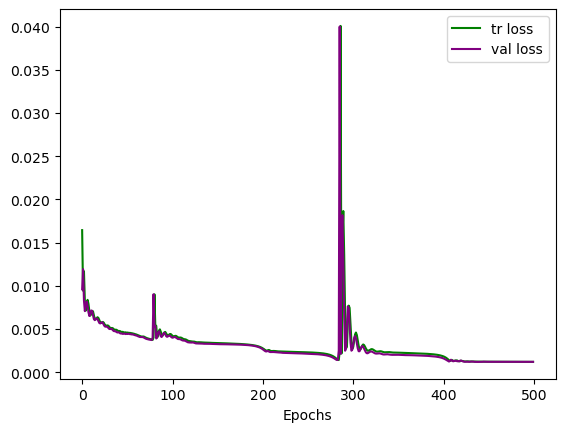

In [17]:
plt.plot(best_tr_loss_list, label='tr loss', color='green')
plt.plot(best_val_loss_list, label='val loss', color='purple')
plt.xlabel('Epochs')
plt.legend()

## Retrain

Retrain on full development (train + validation) set with the best hyperparams found in the grid search.

In [12]:
lr = 0.005
gamma = 0.999
hidden_size = 32
activation = 'tanh'
init = 'zero'

num_epochs = 1000
input_size = devel_input.size(1)

In [15]:
retrain_rnn_model, loss_function, optimizer, scheduler = init_network(input_size, hidden_size, lr, gamma, activation, init, device=device)

In [31]:
# Save retrain model for each epoch
rnn_retrain_checkpoint_folder = 'rnn_retrain_checkpoints'
if not os.path.exists(rnn_retrain_checkpoint_folder):
        os.makedirs(rnn_retrain_checkpoint_folder)

retrain_loss_list = []

# Epochs loop
pbar = tqdm(range(num_epochs)) 
for epoch in pbar:
    # Train the model
    tr_loss, preds, retrain_rnn_model, optimizer, scheduler = train_rnn(devel_input, devel_target, retrain_rnn_model, loss_function, optimizer, scheduler, device=device)
    retrain_loss_list.append(tr_loss)

    pbar.set_description(f"Retrain Loss: {tr_loss.item():0.4f}")

     # Save
    model_save_pth = os.path.join(rnn_retrain_checkpoint_folder, 'rnn_{}.pt'.format(epoch))
    torch.save({
                'epoch': epoch,
                'model_state_dict': retrain_rnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schdeduler_state_dict': scheduler.state_dict(),
                'tr_loss': tr_loss,
                'tr_preds': preds
                }, model_save_pth)
    
retrain_loss_list = torch.Tensor(retrain_loss_list).cpu().tolist()

Retrain Loss: 0.0011: 100%|██████████| 1000/1000 [00:09<00:00, 100.02it/s]


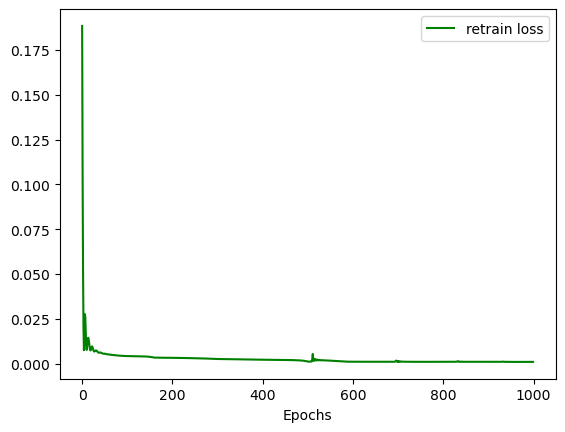

In [32]:
plt.plot(retrain_loss_list, label='retrain loss', color='green')
plt.xlabel('Epochs')
plt.legend()

In [33]:
print('Best retrain loss: {} at epoch {}'.format(min(retrain_loss_list), retrain_loss_list.index(min(retrain_loss_list))))

Best retrain loss: 0.0010353575926274061 at epoch 981


In [34]:
retrain_loss_list

[0.18832215666770935,
 0.10674196481704712,
 0.05249771103262901,
 0.019570697098970413,
 0.007575538475066423,
 0.016400448977947235,
 0.027635803446173668,
 0.025818834081292152,
 0.0171195100992918,
 0.009963504038751125,
 0.007724352180957794,
 0.009508945979177952,
 0.012543142773211002,
 0.01443485263735056,
 0.01435522735118866,
 0.012714081443846226,
 0.010439598932862282,
 0.008467999286949635,
 0.0074462261982262135,
 0.007554843556135893,
 0.008438664488494396,
 0.009366889484226704,
 0.009697949513792992,
 0.0092777693644166,
 0.008408398367464542,
 0.00753659475594759,
 0.006978016346693039,
 0.006818016059696674,
 0.006957404315471649,
 0.007214570418000221,
 0.007417501416057348,
 0.007458887994289398,
 0.007313501555472612,
 0.007027138955891132,
 0.006688236724585295,
 0.006392272654920816,
 0.0062081883661448956,
 0.0061556557193398476,
 0.00620094733312726,
 0.0062746647745370865,
 0.006305255927145481,
 0.006252225488424301,
 0.006121186073869467,
 0.005953893065452

Chosen epoch for retrained RNN: 981.

In [16]:
final_retrain_pth = './rnn_retrain_checkpoints/rnn_981.pt'

output_size = 1
best_rnn_retrain = rnn(input_size, hidden_size, output_size, num_layers=1, nonlinearity=activation)
best_rnn_retrain.load_state_dict(torch.load(final_retrain_pth)['model_state_dict'])

# Preds of the best epoch rnn retrain model
retrain_preds = torch.load(final_retrain_pth)['tr_preds']

Plot predicted and true values of the series for the development set.

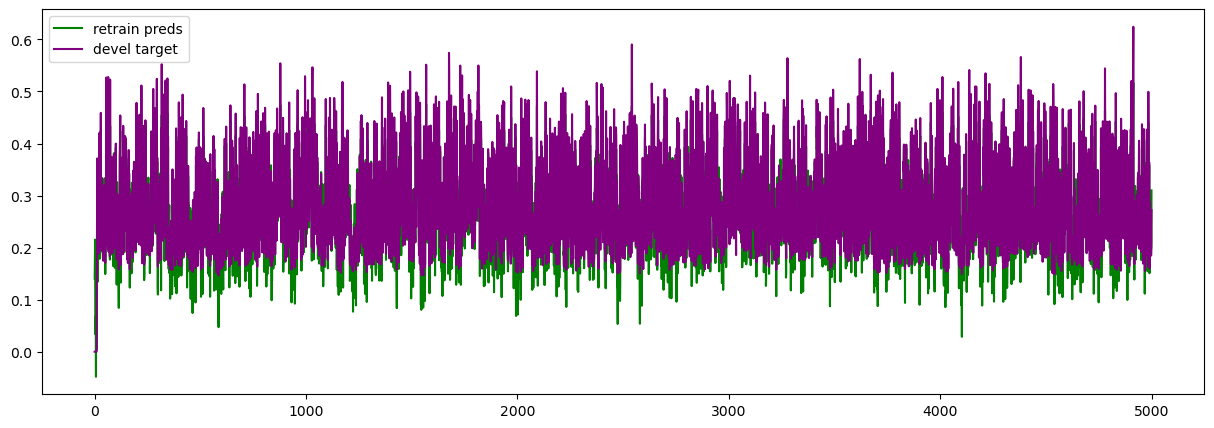

In [17]:
plt.plot(retrain_preds, label='retrain preds', color='green')
plt.plot(devel_target, label='devel target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()

Show test predictions of the first 1000 elems.

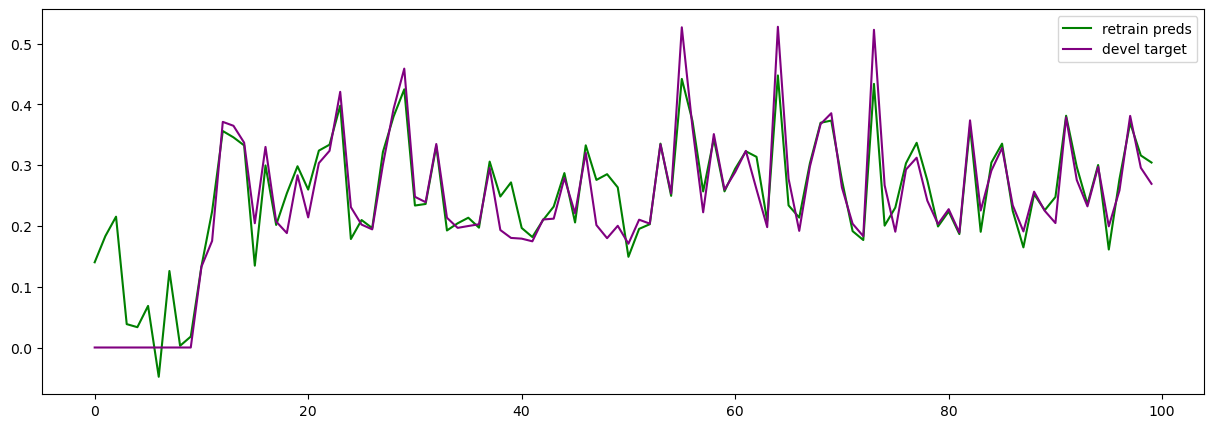

In [18]:
plt.plot(retrain_preds[:100], label='retrain preds', color='green')
plt.plot(devel_target[:100], label='devel target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()

## Test

Get test predictions.

In [19]:
# Save test preds and loss

test_loss, test_preds = eval_rnn(test_input, test_target, best_rnn_retrain, loss_function)
torch.save({
            'test_loss': test_loss,
            'test_preds': test_preds
}, 'rnn_test_results.pt')

print('Test loss: ', test_loss.item())

Test loss:  0.0011020076926797628


Plot predicted and true values of the series for the test set.

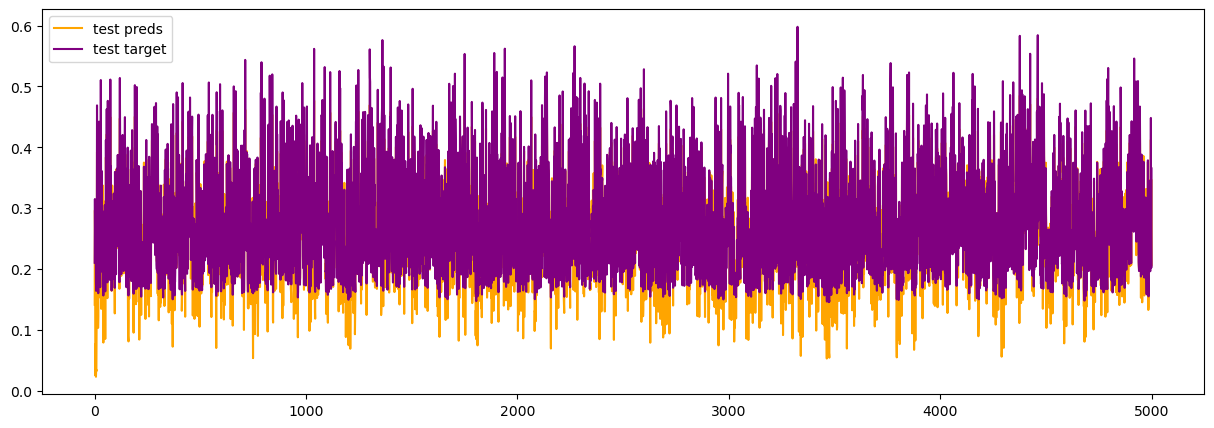

In [20]:
plt.plot(test_preds, label='test preds', color='orange')
plt.plot(test_target, label='test target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()

Show test predictions vs targets of the first 100 elems.

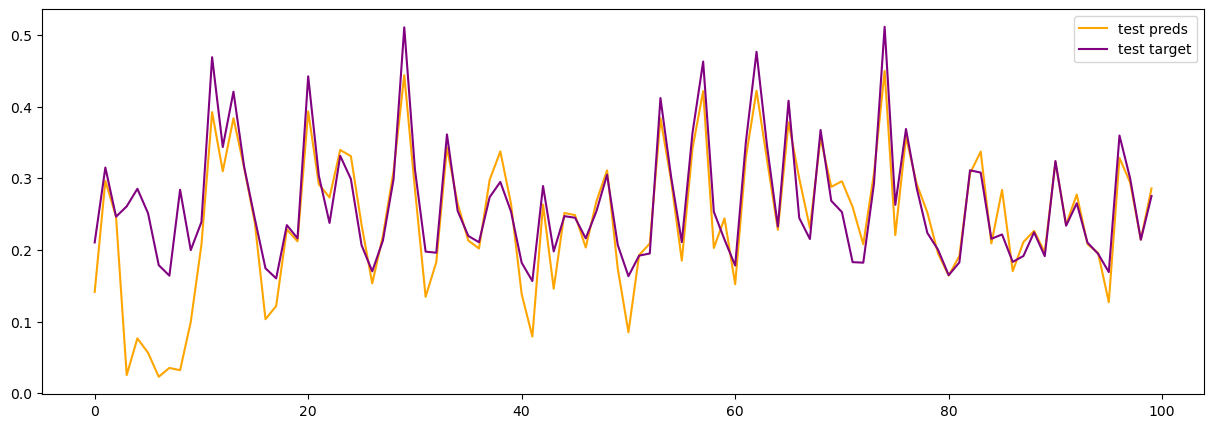

In [21]:
plt.plot(test_preds[:100], label='test preds', color='orange')
plt.plot(test_target[:100], label='test target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()